# Automatically Pruning Redundant Features With KXY

## The Problem

Redundant features or explanatory are problematic. They might cause numerical instabilities during model training, or result in models that are too big. 

Models that are too big are typically harder to explain, they are more subject to 'data-drift' and require more frequent recalibration, they are more likely to be affected by an outage of the data/feature serving pipeline in production, and they tend to be costlier to train and might not perform as well as smaller models.

Detecting and pruning redundant explanatory variables or features is thereof key to cost-effective modeling.

In this case study, we illustrate that the `kxy` package may be use to seemlessly detect and prune redundant features.

We use the small UCI Bank Note dataset so that we may validate the findings of the `kxy` package using a visual/qualitative analysis. However, all conclusions extend to problems with far more explanatory variables/features. 

The goal in the UCI Bank Note experiment is to use properties of a picture of a bank note to determine whether the note is a forgery.

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["NUMEXPR_MAX_THREADS"] = '8'
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pandas as pd
import kxy

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [2]:
# Load the data using the kxy_datasets package (pip install kxy_datasets)
from kxy_datasets.uci_classifications import BankNote
df = BankNote().df

# Next, we normalize the data so that each input takes value in $[0, 1]$, so as to ease visualization. 
# All input importance analyses performed by the `kxy` package are robust to increasing transformations, 
# including the foregoing normalization. Nonetheless, we will take a copy of the data before normalization,
# which we will use for analyses, the normalized data being used for visualization only.
ef = df.copy() # Copy used for analysis.
# Normalization to ease vizualization
df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']] = \
    (df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']] - \
     df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']].min(axis=0))
df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']] /= \
    df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']].max(axis=0)

## Qualitative Variable Selection

### Intuition

We begin by forming an intuition for what we would expect out of a variable importance analysis.

#### Univariate Variable Importance
Intuitively, saying that an input $x_i$ is informative about a categorical label $y$ (when used in isolation) is the same as saying that observing the value of $x_i$ is useful for inferring the value of the label/class $y$. For this to be true, it ought to be the case that the collection of values of $x_i$ corresponding to a given value of $y$ should be sufficiently different from the collections of values of $x_i$ corresponding to the other classes. 

The more these collections are *different*, the less ambiguity there will be in inferring $y$ from $x_i$, and therefore the more useful $x_i$ will be for inferring $y$ in isolation.

In the case of the bank note dataset, for every one of the four inputs of interest, we can plot all values on the same line, and color each point red or green depending on whether the observed input came from a fake note or not. 

The more distinguishable the collection of red ticks is from the collection of green ticks, the more the corresponding input is useful at predicting whether or not a bank note is a forgery.

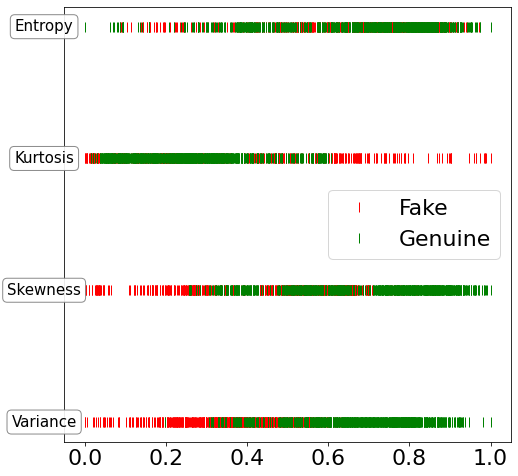

In [3]:
import pylab as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

y = df['Is Fake'].values.astype(bool)
v = df['Variance'].values
s = df['Skewness'].values
k = df['Kurtosis'].values
e = df['Entropy'].values

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.plot(v[y], 0.0*np.ones_like(v[y]), '|', color='r', linewidth=2, markersize=10,\
        label='Fake')
ax.plot(v[~y], 0.0*np.ones_like(v[~y]), '|', color='g', linewidth=2, markersize=10,\
        label='Genuine')
ax.text(-0.1, 0, "Variance", ha="center", va="center", size=15, bbox=bbox_props)
ax.plot(s[y], 0.1*np.ones_like(s[y]), '|', color='r', linewidth=2, markersize=10)
ax.plot(s[~y], 0.1*np.ones_like(s[~y]), '|', color='g', linewidth=2, markersize=10)
ax.text(-0.1, 0.1, "Skewness", ha="center", va="center", size=15, bbox=bbox_props)
ax.plot(k[y], 0.2*np.ones_like(k[y]), '|', color='r', linewidth=2, markersize=10)
ax.plot(k[~y], 0.2*np.ones_like(k[~y]), '|', color='g', linewidth=2, markersize=10)
ax.text(-0.1, 0.2, "Kurtosis", ha="center", va="center", size=15, bbox=bbox_props)
ax.plot(e[y], 0.3*np.ones_like(e[y]), '|', color='r', linewidth=2, markersize=10)
ax.plot(e[~y], 0.3*np.ones_like(e[~y]), '|', color='g', linewidth=2, markersize=10)
ax.text(-0.1, 0.3, "Entropy", ha="center", va="center", size=15, bbox=bbox_props)
ax.axes.yaxis.set_visible(False)
plt.legend()
plt.show()

In [4]:
'Percentage of points with a normalized kurtosis higher than 0.6: %.2f%%' %\
    (100.*(df['Kurtosis'] > 0.6).mean())

'Percentage of points with a normalized kurtosis higher than 0.6: 7.43%'

Clearly, from the plot above, it is visually very hard to differentiate genuine bank notes from forgeries solely using the `Entropy` input. 

As for the `Kurtosis` variable, while a normalized kurtosis higher than 0.6 is a strong indication that the bank note is a forgery, this only happens about 7% of the time. When the normalized kurtosis is lower than 0.6 on the other hand, it is very hard to distinguish genuine notes from forgeries using the kurtosis alone. 

The `Skewness` input is visually more useful than the previously mentioned two inputs, but the `Variance` input is clearly the most useful. Genuine bank notes tend to have a higher variance, and forgeries tend to have a lower variance.

#### Incremental Variable Importance

To figure out which of the three remaining inputs would complement `Variance` the most, we make three 2D scatter plots with `Variance` as the x-axis and the other input as the y-axis and, as always, we color dots green (resp. red) when the associated inputs came from a genuine (resp. fake) bank note. 

Intuitively, the input that complements `Variance` the best is the one where the collections of green and red points are the most distinguishable. The more distinguishable these two collections, the more accurate it would be to predict whether the bank note is a forgery. The more the two collections overlap, the more ambiguous our prediction will be.

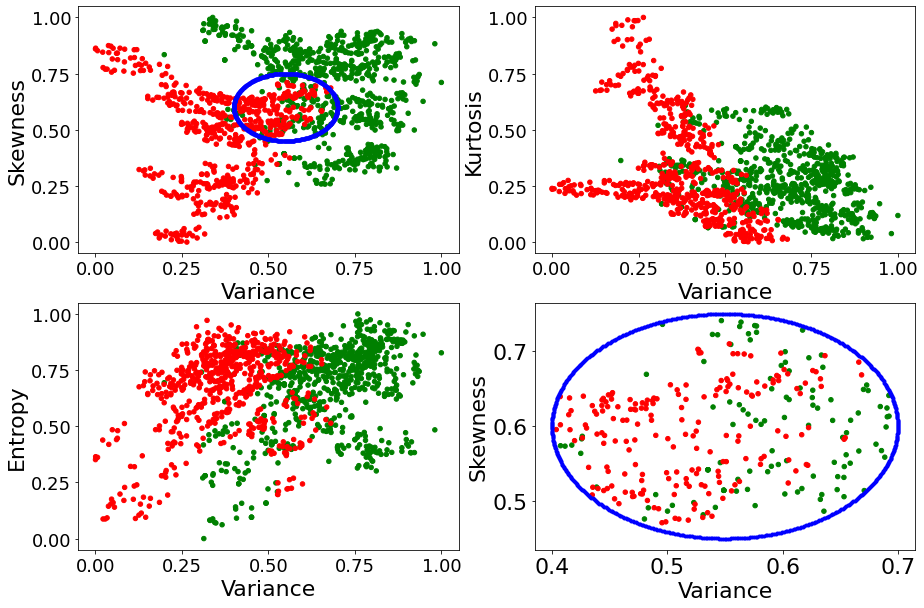

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
df.plot.scatter(ax=ax[0, 0], x='Variance', y='Skewness', c=df['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'), fontsize=18)
df.plot.scatter(ax=ax[0, 1], x='Variance', y='Kurtosis', c=df['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'), fontsize=18)
df.plot.scatter(ax=ax[1, 0], x='Variance', y='Entropy', c=df['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'), fontsize=18)
theta = np.arange(0, 2*np.pi, 0.01)
bound_x = 0.55 + 0.15*np.cos(theta)
bound_y = 0.6 + 0.15*np.sin(theta)
ax[0, 0].plot(bound_x, bound_y, '.', c='b')

selector = (((df['Variance']-0.55)/0.15)**2 + ((df['Skewness']-0.6)/0.15)**2) <=1
cf = df[selector]
cf.plot.scatter(ax=ax[1, 1], x='Variance', y='Skewness', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
ax[1, 1].plot(bound_x, bound_y, '.', c='b')
plt.show()

As it can be seen above, it is in the plot `Variance` x `Skewness` that the collections of green and red points overlap the least. Thus, one would conclude that `Skewness` is the input that should be expected to complement `Variance` the most.

To qualitatively determine which of `Entropy` or `Kurtosis` would complement the pair (`Variance`, `Skewness`) the most, we identity values of the pair (`Variance`, `Skewness`) that are jointly inconclusive about whether the bank note is a forgery. This is the region of the `Variance` x `Skewness` plane where green dots and red dots overlap. We have crudely identified this region in the top-left plot with the blue ellipse, a zoomed-in version thereof is displayed in the bottom-right plot. 

We then seek to know which of `Entropy` and `Kurtosis` can best help alleviate the ambiguity inherent to that region. To do so, we consider all the bank notes that fall within the blue ellipse above, and we plot them on the four planes `Variance` x `Kurtosis`, `Variance` x `Entropy`, `Skewness` x `Kurtosis`, and `Skewness` x `Entropy`, in an attempt to figure out how much ambiguity we can remove at a glance by knowing `Entropy` or `Kurtosis`.

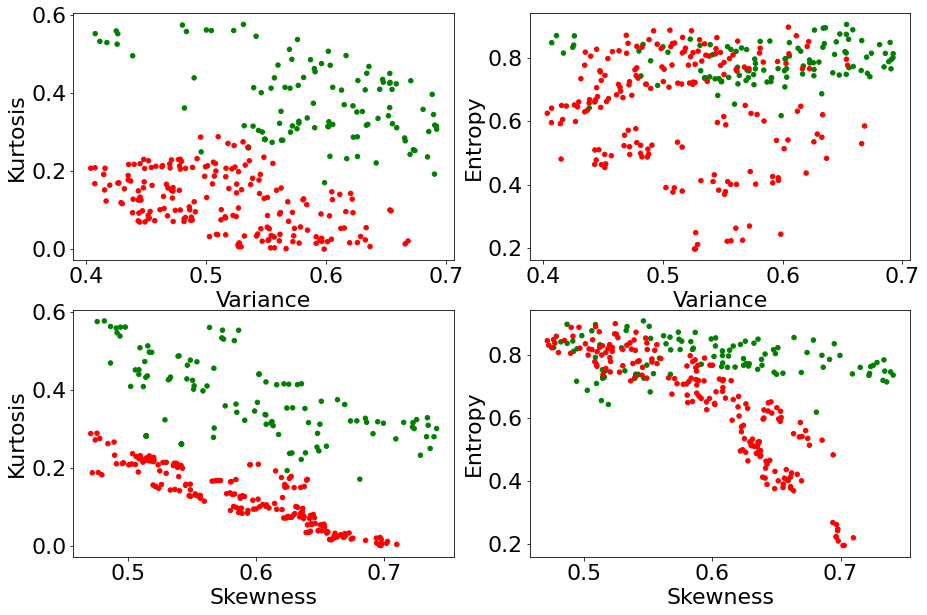

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
cf.plot.scatter(ax=ax[0, 0], x='Variance', y='Kurtosis', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
cf.plot.scatter(ax=ax[0, 1], x='Variance', y='Entropy', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
cf.plot.scatter(ax=ax[1, 0], x='Skewness', y='Kurtosis', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
cf.plot.scatter(ax=ax[1, 1], x='Skewness', y='Entropy', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
plt.show()

As it turns out, knowing the value of the input `Kurtosis` allows us to almost perfectly differentiate genuine notes from forgeries, among all notes that were previously ambiguous to tell apart solely using `Variance` and `Skewness`. On the other hand, although it helps alleviate some ambiguity, the input `Entropy` appears not as effective as `Kurtosis`.

Thus, the third input in decreasing order of marginal usefulness is expected to be `Kurtosis`, `Entropy` being the least marginally useful.

To summarize, we expect a decent variable selection analysis to select variables in the order `Variance` $\to$ `Skewness` $\to$ `Kurtosis` $\to$ `Entropy`. 

We expect the contribution of `Entropy` to be negligible, and the overall achievable accuracy to be close to 100%. 

## Quantitative Validation 

Let us validate that the variable selection analysis of the `kxy` package satisfies these properties.

In [7]:
var_selection_analysis = ef.kxy.variable_selection('Is Fake', problem_type='classification')

[====================================================================================================] 100% ETA: 0s   


In [8]:
var_selection_analysis

,Variable,Running Achievable R-Squared,Running Achievable Accuracy
Selection Order,,,
0,No Variable,0.00,0.56
1,Variance,0.51,0.90
2,Skewness,0.58,0.93
3,Kurtosis,0.75,1.00
4,Entropy,0.75,1.00


The `kxy` package selected variables in the same order as our qualitative analysis (see the `Selection Order` column).

More importantly, we see that the `kxy` package was able to determine that `Entropy` is redundant once we know the other 3 variables.